# Mini Project - Building a 2 bit adder on a quantum computer 

Until now we have only used simulators with no (or negligible) noise to do the computational tasks necessary. However, Quantum Computers today are far from ideal and noiseless. As coined by John Preskill we are in the [Noisy Intermediate Scale Quantum (NISQ)](https://arxiv.org/abs/1801.00862) era where our quantum computers are of the intermediate scale (50-100 qubits) and are very noisy, for example, a qubit initialized in the $|0\rangle$ state might not give $0$ on measurement in the computational basis all the time.

To understand the statement above lets do an experiment on a noiseless simulator and on an actual quantum computer and compare the results. 

### Simulator

In [3]:
%matplotlib inline
from qiskit import QuantumCircuit, execute, Aer
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
import numpy as np

In [7]:
qc = QuantumCircuit(1, 1)
qc.x(0)
qc.measure(0,0)
qc.draw()

┌───┐┌─┐
q_0: ┤ X ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

Once we build our circuit lets use the `qasm_simulator` from Aer to get the measurement counts

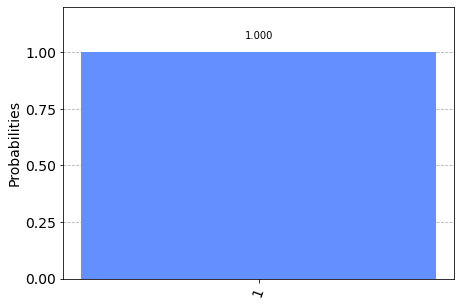

In [8]:
backend = Aer.get_backend("qasm_simulator")
job = execute(qc,backend=backend, shots =1000)
counts = job.result().get_counts()
plot_histogram(counts)

As you'd expect we received all 1000 counts to be corresponding to `1`. Now lets do the same experiment on a real device. 

### Real device

To run your experiments on a real device you'll first need to create(login into) an [IBM Quantum Experience](https://www.ibm.com/quantum-computing/technology/experience/) account and follow the instructions given [here](https://qiskit.org/documentation/install.html#install-access-ibm-q-devices-label) to be able to access IBM quantum services form Qiskit.

In [9]:
# only run this cell once, running it the second time might raise an error/warning as save_account() already has your token stored
from qiskit import IBMQ

# to enabble your account you'll need to enter your token from IBM Quantum Experience in 'YOUR_IBM_TOKEN' in a string format 
IBMQ.save_account('YOUR_IBM_TOKEN')

configrc.store_credentials:WARNING:2021-04-03 02:12:06,731: Credentials already present. Set overwrite=True to overwrite.


In [10]:
# loading your account
IBMQ.load_account() 

# Getting a backend for running the circuit on. In this case 'ibm_armonk'. For more devices you have access to you 
# can look into your IBM Q Experience account's dashboard.
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend("ibmq_armonk")

In [11]:
job = execute(qc,backend=backend,shots =1000)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


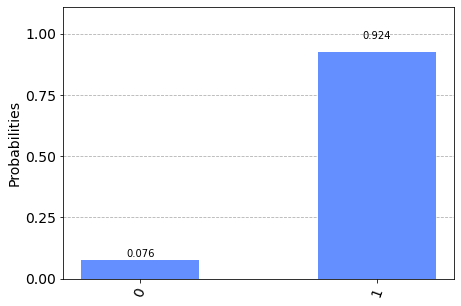

In [12]:
counts = job.result().get_counts()
plot_histogram(counts)

From the above histogram we see that not all the counts resulted in a `1`. This is an example of the noise that gates induce. It's important to note that different gates induce different levels of noise into the system. For example, 2-qubit gates induce a lot more noise into the system than single qubit gates, hence while creating circuits to be run on real devices we should be wary of the number of 2-qubit gates being used and try to reduce them as much as possible. This idea will be the essence of the mini-project today. [Chapter 5 of the Qiskit Textbook](https://qiskit.org/textbook/ch-quantum-hardware/index-circuits.html) delves deeper into noise and some methods to tackle it if you're interested in learning more. 

While in today's mini-project we won't be working with noisy simulators or real devices, lets take a step forward in understanding how to build circuits that give better results in the presence of noise. To do that lets dive into the exercise: 

## Mini-Project: Construct a 3 digit binary adder circuit with minimum cost.

[Chapter 1.2](https://qiskit.org/textbook/ch-states/atoms-computation.html) of the Qiskit Textbook explains how to construct a binary half adder. Using that knowledge we want you to create a 3 digit binary adder circuit which can do any three digit computation such as $101 + 110 = 1011$ where each input is a 3 digit binary number and the output is a four digit binary number. Your task is to find such a circuit with the least cost possible. The exercise is intentionally defined without many constraints to give you the freedom to test different data encoding schemes, basis gate sets, etc. (The 3 digit adder problem is optional. You will be greaded over the 2 bit adder problem)

Let us now define our cost function: 

**Cost of the circuit = Number of Single qubit gates + 10 $\times$ Number of CX gates** 

### The cost function

Any given quantum circuit can be decomposed into single-qubit and `CX` gates as they are a set of [universal quantum gates](https://en.wikipedia.org/wiki/Quantum_logic_gate#Universal_quantum_gates). With the current Noisy Intermediate-Scale Quantum (NISQ) devices noise introduced is higher when implementing a `CX` gate. Therefore, we  weigh `CX` gates 10 times more than a single-qubit gate while evaluating the cost of our circuit. To evaluate the cost of your circuit you can use the `cost_function()` method given below. 

The `cost_function()` takes as **input**: 

* `circuit`: (`QuantumCircuit`) -- The quantum circuit for which you'd like to find the cost.

And gives as **output**:


* `circuit_cost`: (`a`) -- Cost of the circuit


* `gates`: (`Dict`) -- Dictionary with the number of gates used in the circuit


* `unrolled_circuit`: (`QuantumCircuit`) -- The resultant circuit after change of basis

In [15]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller


def cost_function(circuit):
    if not isinstance(circuit, (QuantumCircuit)):
        print("the inserted circuit must be a QuantumCircuit object, not {}".format(type(circuit)))
    else:
        basis_gate_set = ['u3', 'cx'] # basis that we are unrolling the circuit into

        # changing our basis using an Unroller
        pass_ = Unroller(basis_gate_set)
        pm = PassManager(pass_)
        unrolled_circuit = pm.run(circuit)

        # calculating the cost function using the equation given above
        gates = unrolled_circuit.count_ops()
        circuit_cost = gates['u3'] + 10*gates['cx']
        
    return circuit_cost, gates, unrolled_circuit

Internally, the `cost_function()` method uses an `Unroller` pass to convert our circuit to the {'u3', 'cx'} basis gate set and then applies the cost function equation as defined above. Here are a few resources to understand how the transpiler works: 

* Qiskit Terra Documentation - [Transpiler](https://qiskit.org/documentation/apidoc/transpiler.html)
* Advanced Circuit Tutorial - [Tranpiler Passes and Pass Manager](https://qiskit.org/documentation/tutorials/circuits_advanced/4_transpiler_passes_and_passmanager.html)


Let's understand how to use the `cost_function()` method by applying it on a half adder circuit as given in [Chapter 1.2](https://qiskit.org/textbook/ch-states/atoms-computation.html) of the Qiskit Textbook. 

In [5]:
# Example constructing the Half Adder circuit

qc_ha = QuantumCircuit(4,2)

# ENCODE INPUTS in qubits 0 and 1
qc_ha.x(0) # For a=0, remove the this line. For a=1, leave it.
qc_ha.x(1) # For b=0, remove the this line. For b=1, leave it.
qc_ha.barrier() # barrier is mainly used in this code to make the circuit more readable


# use cnots to write the XOR of the inputs on qubit 2
qc_ha.cx(0,2)
qc_ha.cx(1,2)
# use ccx to write the AND of the inputs on qubit 3
qc_ha.ccx(0,1,3)
qc_ha.barrier()
# extract outputs
qc_ha.measure(2,0) # extract XOR value
qc_ha.measure(3,1) # extract AND value

qc_ha.draw()

┌───┐ ░                 ░       
q_0: ┤ X ├─░───■─────────■───░───────
     ├───┤ ░   │         │   ░       
q_1: ┤ X ├─░───┼────■────■───░───────
     └───┘ ░ ┌─┴─┐┌─┴─┐  │   ░ ┌─┐   
q_2: ──────░─┤ X ├┤ X ├──┼───░─┤M├───
           ░ └───┘└───┘┌─┴─┐ ░ └╥┘┌─┐
q_3: ──────░───────────┤ X ├─░──╫─┤M├
           ░           └───┘ ░  ║ └╥┘
c: 2/═══════════════════════════╩══╩═
                                0  1

Now, let's do a crude check to see if our circuit is working. let us first initialize our qubit `q_0` and `q_1` to check what the value of `1 + 1` would be in binary. We know that the sum bit (`q_2`) should be `0` and the carry bit (`q_3`) should be `1`. 

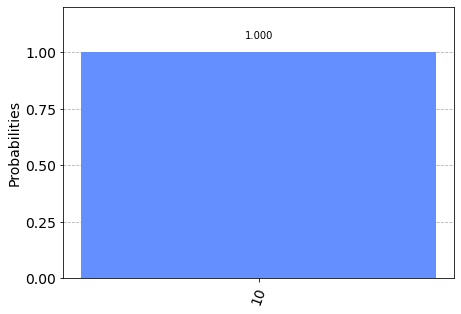

In [6]:
backend = Aer.get_backend("qasm_simulator")
job = execute(qc_ha,backend=backend, shots =1000)
counts = job.result().get_counts()
plot_histogram(counts)

Note that the [qubit ordering in qiskit is opposite](https://youtu.be/EiqHj3_Avps) to what you'd expect. So, the answer of `10` that showed up 100% of the time is actually `01`, as we'd expect. Go ahead and change the initialization of the states `q_0` and `q_1` to cross-check with other addition values. Now, we shall run the `cost_function()` and get the `cost` of the circuit.

In [16]:
circuit_cost, gates, unrolled_circuit = cost_function(qc_ha)

print('Cost of the circuit : {}'.format(circuit_cost))
print('Gates counts after unrolling : {}'.format(gates))
print('Circuit after unrolling :')
unrolled_circuit.draw()

Cost of the circuit : 91
Gates counts after unrolling : OrderedDict([('u3', 11), ('cx', 8), ('barrier', 2), ('measure', 2)])
Circuit after unrolling :


┌───────────┐ ░                                               »
q_0: ┤ U3(π,0,π) ├─░────────■───────────────────────────────────■──»
     ├───────────┤ ░        │                                   │  »
q_1: ┤ U3(π,0,π) ├─░────────┼─────────■────■────────────────────┼──»
     └───────────┘ ░      ┌─┴─┐     ┌─┴─┐  │                    │  »
q_2: ──────────────░──────┤ X ├─────┤ X ├──┼────────────────────┼──»
                   ░ ┌────┴───┴────┐└───┘┌─┴─┐┌──────────────┐┌─┴─┐»
q_3: ──────────────░─┤ U3(π/2,0,π) ├─────┤ X ├┤ U3(0,0,-π/4) ├┤ X ├»
                   ░ └─────────────┘     └───┘└──────────────┘└───┘»
c: 2/══════════════════════════════════════════════════════════════»
                                                                   »
«                                                             ┌─────────────┐ »
«q_0: ──────────────────────────────────────■─────────■───────┤ U3(0,0,π/4) ├─»
«                         ┌─────────────┐   │       ┌─┴─┐     ├─────────────┴┐»
«q_1: ─────────────────■──┤ U3(0,0,π/4) ├───┼───────┤ X ├─────┤ U3(0,0,-π/4) ├»
«                      │  └─────────────┘   │       └───┘     └──────────────┘»
«q_2: ─────────────────┼────────────────────┼─────────────────────────────────»
«     ┌─────────────┐┌─┴─┐┌──────────────┐┌─┴─┐┌─────────────┐┌─────────────┐ »
«q_3: ┤ U3(0,0,π/4) ├┤ X ├┤ U3(0,0,-π/4) ├┤ X ├┤ U3(0,0,π/4) ├┤ U3(π/2,0,π) ├─»
«     └─────────────┘└───┘└──────────────┘└───┘└─────────────┘└─────────────┘ »
«c: 2/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«           ░       
«q_0: ──■───░───────
«     ┌─┴─┐ ░       
«q_1: ┤ X ├─░───────
«     └───┘ ░ ┌─┐   
«q_2: ──────░─┤M├───
«           ░ └╥┘┌─┐
«q_3: ──────░──╫─┤M├
«           ░  ║ └╥┘
«c: 2/═════════╩══╩═
«              0  1

## Sub-Task 1 :- Build a Full Adder

You can check out [this](https://www.geeksforgeeks.org/full-adder-in-digital-logic/#:~:text=Full%20Adder%20is%20the%20adder,as%20S%20which%20is%20SUM.) geeks for geeks page for an explanation of what a full adder is. Now try to use the ideas we have developed before to extend our half adder to a full adder circuit.

In [1]:
# code the full adder here

# demonstrate that it works by adding a few digits 

## Final Task 2 :- Build a 2 binary digit adder

Now that we have a half adder and a full adder we're all set to combine them and build a 2 digit adder which can do arbitrary two digit additions such as `11 + 01 = 100`, etc. 

In [ ]:
# code the 2 digit adder here

# demonstrate that it works by adding a few digits 

## Optional Task :- Build the 3 binary digit adder

Yup, you guessed it right! It's just an extension to the 2 digit binary adder!

In [ ]:
# code the 2 digit adder here

# demonstrate that it works by adding a few digits 

Once you have built your circuit encode different three digit binary strings and see if your circuit is giving the correct answer for all of them. If it is, then congratulations on learning how to build an adder on a quantum computer!! You will be awarded points based on whether your circuit is providing the correct results for the examples you've shown 

Next, use the `cost_function()` to get the `cost` of your circuit and cross-check it with your friends in the discord channel! See who gets to a lower circuit cost and exchange ideas on how to optimize the circuit. Have fun!!

### For the one's who dare

* Try to implement this circuit using lesser number of qubits    
* Try this circuit out on a real quantum computer and see how much the results vary due to noise.   
* Try and optimize the cost and see if the results improve on the real device. 